In [12]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [13]:
# Download the data
if not os.path.exists('data/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
if not os.path.exists('data/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

# Q4: Efficient Tracking

Makes process faster by computing $p$ from the affine warp and the change in the affine warp, such that 

$$ M = M(\Delta M)^{-1}   $$

## Q4.1: Inverse Composition (15 points)

In [14]:
from scipy.interpolate import RectBivariateSpline

def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    def apply_affine_warp(pixels, warp_matrix, H,W):
        pixels = warp_matrix @ pixels
        return pixels[0].reshape(H,W), pixels[1].reshape(H,W)
    
    def build_jacobian(X, Y):
        X_flat = X.ravel()
        Y_flat = Y.ravel()

        ones = np.ones_like(X_flat)
        zeros = np.zeros_like(X_flat)
        J = np.stack([
            np.stack([X_flat, Y_flat, ones, zeros, zeros, zeros], axis=-1),
            np.stack([zeros, zeros, zeros, X_flat, Y_flat, ones], axis=-1)
        ], axis=1)  # shape: (n, 2, 6)
        return J
    
    def in_bounds(x, y, H, W):
        mask = np.where((x >= 0) & (x < W) & (y >= 0) & (y < H), True, False)
        return mask
    
    # Initial transform parameters
    warp_matrix = np.array([
        [1.0, 0.0, 0.0], 
        [0.0, 1.0, 0.0]
    ])
    # Create image splines
    H, W = It.shape
    spline_t0 = RectBivariateSpline(np.arange(H), np.arange(W), It)
    spline_t1 = RectBivariateSpline(np.arange(H), np.arange(W), It1)

    # Create gradient splines
    I_dy = np.gradient(It1, axis=0)
    I_dx = np.gradient(It1, axis=1)
    grad_spline_dx = RectBivariateSpline(np.arange(H), np.arange(W), I_dx)
    grad_spline_dy = RectBivariateSpline(np.arange(H), np.arange(W), I_dy)

    x1, y1, x2, y2 = 0, 0, W-1, H-1
    rec_x = np.arange(x1, x2+1)
    rec_y = np.arange(y1, y2+1)
    X, Y = np.meshgrid(rec_x, rec_y)
    template_t0 = spline_t0.ev(Y, X) # Sample the template from It
    # Make homogenous
    pixels_hg = np.stack([X.flatten(), Y.flatten(), np.ones_like(X.flatten())], axis=0)
    
    dx = grad_spline_dx.ev(Y, X).flatten()
    dy = grad_spline_dy.ev(Y, X).flatten()
    image_grad = np.vstack([dx, dy]).T
    
    J = build_jacobian(X, Y)
    A_prime = np.einsum('ij,ijk->ik', image_grad, J)
    
    for i in range(num_iters):
        # Warp the image
        warped_x, warped_y = apply_affine_warp(pixels_hg, warp_matrix, H, W)
        valid_mask = in_bounds(warped_x, warped_y, H, W)

        warped_x, warped_y = warped_x[valid_mask], warped_y[valid_mask]
        template_t1 = spline_t1.ev(warped_y, warped_x) # Sample the template from It1

        # Build b by computing the error
        b = (template_t1 - template_t0[valid_mask]).flatten()
        
         # Use A prime to compute change in warp matrix
        A = A_prime[valid_mask.flatten()]
        hessian = A.T @ A   
        delta_p = (np.linalg.inv(hessian)) @ (A.T @ b)

        delta_warp = np.array([
            [1+delta_p[0], delta_p[1], delta_p[2]], 
            [delta_p[3], 1+delta_p[4], delta_p[5]],
            [0, 0, 1]
        ], dtype=np.float32)
        
        warp_matrix = warp_matrix @ np.linalg.inv(delta_warp)

        if np.linalg.norm(delta_p) <= threshold:
            # print(f"Converged at iteration {i}")
            break

    return warp_matrix

## Debug Q4.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

array([[ 9.99652333e-01,  6.89469641e-04, -4.84094925e-01],
       [ 2.94353016e-04,  1.00145991e+00, -1.32414815e-01]])

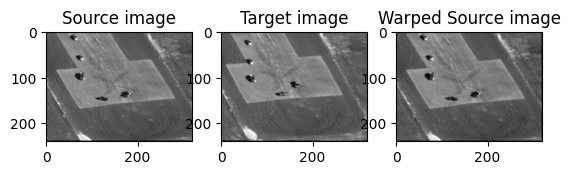

In [15]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("data/aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = InverseCompositionAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')
M

## Q4.2 Tracking with Inverse Composition (10 points)

Re-use your impplementation in Q3.2 for subtract dominant motion. Just make sure to use InverseCompositionAffine within.

In [16]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)
    
    # Warp the image
    M = InverseCompositionAffine(It, It1, threshold, num_iters)
    warped_img = affine_transform(It, M, output_shape=It.shape)

    # Compute abs difference. If difference is high, this is a movement zone
    diff = np.abs(warped_img - It1)
    mask = diff > tolerance

    # Apply morphological operations for better mask
    _kernel_3X3 = np.ones((3,3), np.uint8)
    _kernel_5X5 = np.ones((5,5), np.uint8)
    mask = binary_dilation(mask,structure= _kernel_5X5, iterations=1)
    mask = binary_erosion(mask, structure= _kernel_3X3, iterations=2)
    return mask


Re-use your implementation in Q3.3 for sequence tracking.

In [17]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape
    masks = []
    # Iterate over the car sequence and track the car
    for i in tqdm(range(1, seq.shape[2])):
        frame_0 = seq[:,:,i-1]
        frame_i = seq[:,:,i]
        assert not np.all(frame_0 == frame_i), "The frames are the same"

        mask = SubtractDominantMotion(frame_0, frame_i, num_iters, threshold, tolerance)
        masks.append(mask)

    masks = np.stack(masks, axis=2)
    return masks

Track the ant sequence with inverse composition method.


In [18]:
seq = np.load("data/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [00:13<00:00,  9.11it/s]


Ant Sequence takes 13.616640 seconds


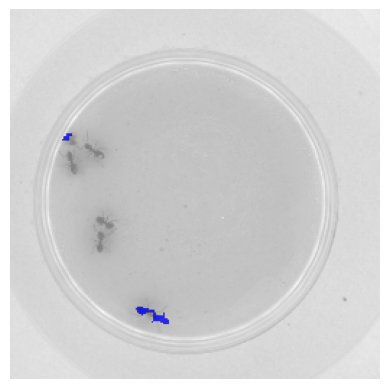

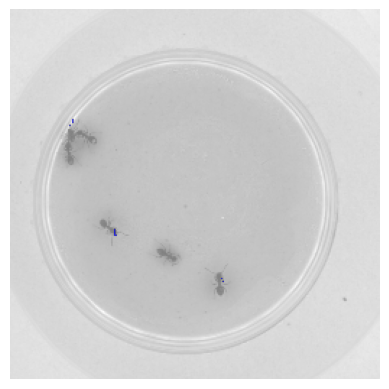

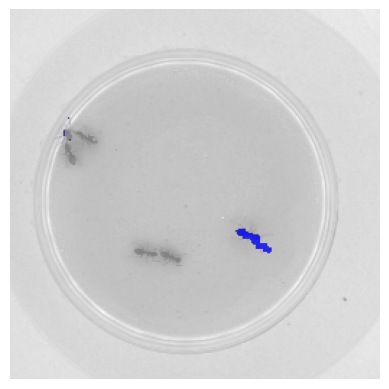

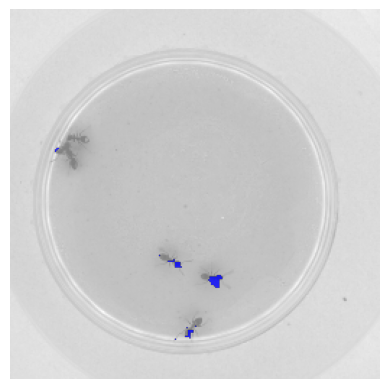

In [19]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


Track the aerial sequence with inverse composition method.


In [20]:
seq = np.load("data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAerial Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [00:28<00:00,  5.26it/s]


Aerial Sequence takes 28.358369 seconds


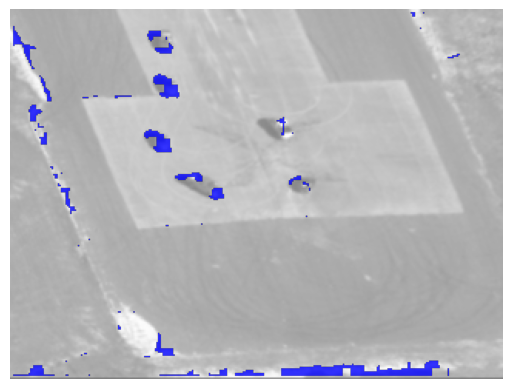

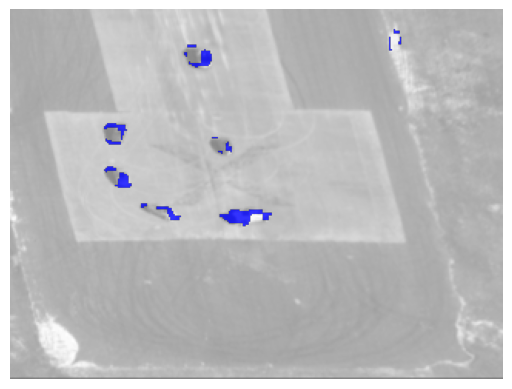

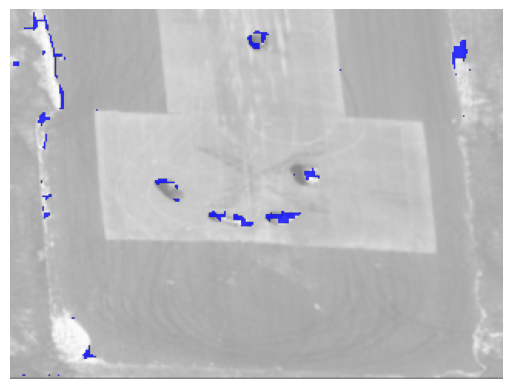

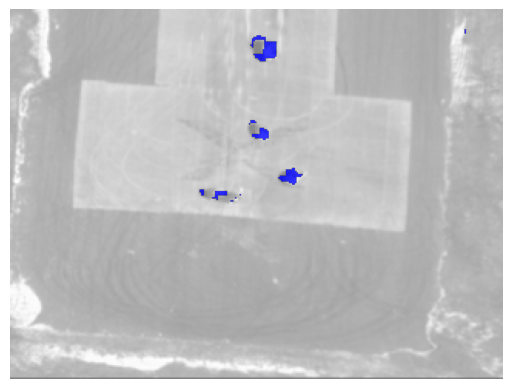

In [21]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')

## Q4.2.1 Compare the runtime of the algorithm using inverse composition (as described in this section) with its runtime without inverse composition (as detailed in the previous section) in the context of the ant and aerial sequences:

**A:** The inverse composition method is **~ 37.96% faster** for the _aerial sequence_ and **~ 27.89%** faster for the _ant sequence_.

For the _aerial sequence_ the runtimes are:

- Classical: 45.703325 seconds
- Inverse Compositional: 28.358369 seconds

For the _ant sequence_ the run times are:

- Classical: 18.500545 seconds
- Inverse Compositional: 13.345252 seconds

## Q4.2.2 In your own words, please describe briefly why the inverse compositional approach is more computationally efficient than the classical approach:

**A:**

In the case of the inverse compositional, the speed it comes from restructuing the problem such that the hessian remains constant and thus can be pre-computed without the need for evaluating in each cycle. This is achieved by _reversing_ the optimization such that we now wish to align the frame to the template. This removes any dependency of the hessian on the warped image itself.

In this way, the only operations performed each cycle are the image warp, and matrix multiplications to estimate the change in parameters $\Delta p$.